In [9]:
#import statements
import pandas as pd
import numpy as np
import ast
import re
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

CoolTone = pd.read_csv('/Users/Ashley Rommel/Downloads/cooltonee.csv')
WarmTone = pd.read_csv('/Users/Ashley Rommel/Downloads/warmtone.csv')

CoolTone["Label"] = 0
WarmTone["Label"] = 1

combined_data = pd.concat([CoolTone, WarmTone], ignore_index=True)

def extract_floats_from_string(val):
    if isinstance(val, str):
        pattern = r"np\.float64\(([-+]?\d*\.\d+|\d+)\)"
        matches = re.findall(pattern, val)
        if len(matches) == 3:
            return [float(match) for match in matches]
    return np.nan

combined_data["YUV_values"] = combined_data["YUV_values"].apply(extract_floats_from_string)

combined_data = combined_data.dropna(subset=["YUV_values"])

print(f"Valid rows after processing: {combined_data['YUV_values'].notna().sum()}")

X = np.array(combined_data["YUV_values"].tolist())
y = combined_data["Label"]

print(f"Feature matrix shape: {X.shape}")
print(f"Label shape: {y.shape}")

# Normalize the feature matrix
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)

print("Accuracy:", accuracy)
print("AUC:", auc)
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Valid rows after processing: 148
Feature matrix shape: (148, 3)
Label shape: (148,)
Accuracy: 0.5333333333333333
AUC: 0.5335968379446641

Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.65      0.59        23
           1       0.53      0.41      0.46        22

    accuracy                           0.53        45
   macro avg       0.53      0.53      0.52        45
weighted avg       0.53      0.53      0.53        45



Number of low-confidence predictions: 14
Number of high-confidence predictions: 31
Low-Confidence Predictions:
   True Label  Predicted Label  Confidence
0           0                0        0.56
1           1                1        0.54
2           1                1        0.52
3           0                1        0.51
4           0                1        0.52


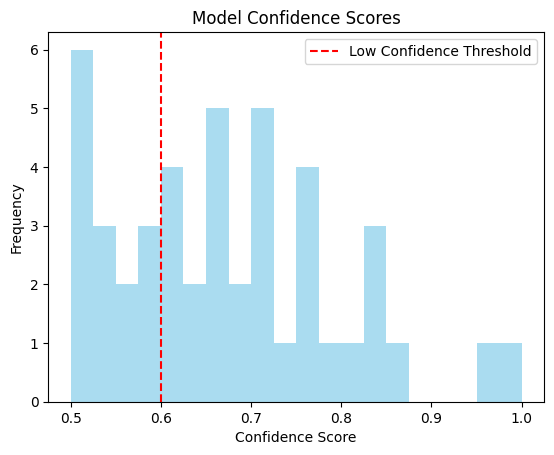

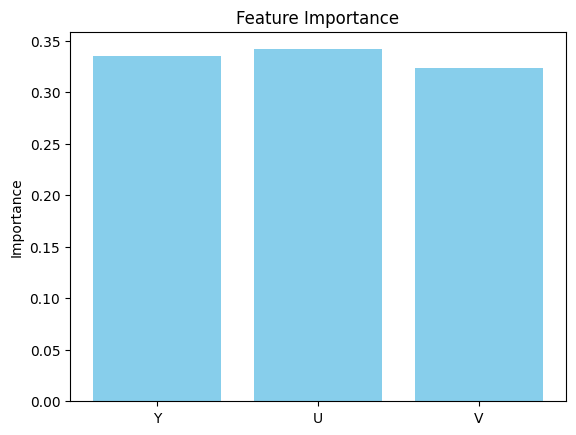

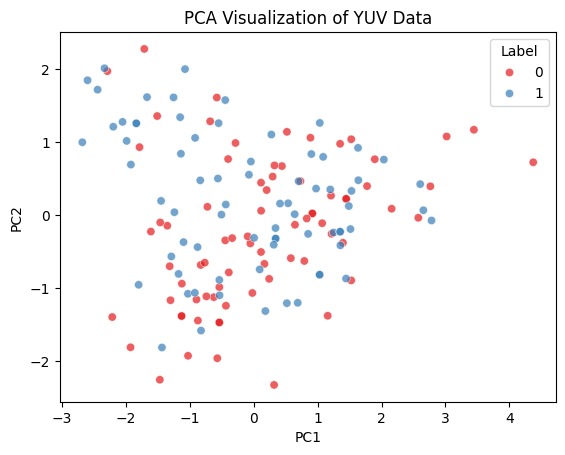

In [14]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns

# Model Uncertainty Evaluation: Confidence Analysis
import numpy as np
confidence_scores = np.max(clf.predict_proba(X_test), axis=1)  # Maximum probability for each prediction

# Confidence analysis for each class
low_confidence_threshold = 0.6
low_confidence_indices = np.where(confidence_scores < low_confidence_threshold)[0]
high_confidence_indices = np.where(confidence_scores >= low_confidence_threshold)[0]

print(f"Number of low-confidence predictions: {len(low_confidence_indices)}")
print(f"Number of high-confidence predictions: {len(high_confidence_indices)}")

# Optional: Inspect low-confidence predictions
low_confidence_data = pd.DataFrame({
    "True Label": y_test.iloc[low_confidence_indices].values,
    "Predicted Label": y_pred[low_confidence_indices],
    "Confidence": confidence_scores[low_confidence_indices]
})
print("Low-Confidence Predictions:")
print(low_confidence_data.head())

# Visualize Confidence Scores
import matplotlib.pyplot as plt
plt.hist(confidence_scores, bins=20, color='skyblue', alpha=0.7)
plt.axvline(low_confidence_threshold, color='red', linestyle='--', label='Low Confidence Threshold')
plt.title("Model Confidence Scores")
plt.xlabel("Confidence Score")
plt.ylabel("Frequency")
plt.legend()
plt.show()

importances = clf.feature_importances_

plt.bar(['Y', 'U', 'V'], importances, color='skyblue')
plt.title("Feature Importance")
plt.ylabel("Importance")
plt.show()

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plot_data = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
plot_data["Label"] = y

sns.scatterplot(data=plot_data, x="PC1", y="PC2", hue="Label", palette="Set1", alpha=0.7)
plt.title("PCA Visualization of YUV Data")
plt.show()



In [ ]:
#high accuracy = 2 groups r distinct. 2 separate pca clusters = distinct groups
#accuracy under 70 = overlapping groups. AUC under 0.69 = overlapping